#  Introduction to Gaussian Processes

在化学信息学和机器学习的世界中，模型通常是树（随机森林、XGBoost 等）或人工神经网络（深度神经网络、图卷积网络等）。这些模型被称为“频率主义者（Frequentist）”模型。然而，还有另一类被称为贝叶斯模型。今天我们将实验一个在 scikit-learn 中实现的贝叶斯模型，称为高斯过程（gaussian processes，GP）。要深入了解GP，有一个很好的[教程论文](https://arxiv.org/pdf/2009.10862.pdf)介绍了GP如何用于回归。还有一篇[学术论文](https://doi.org/10.1002/cmdc.200700041)将GP应用于一个现实世界的问题。

作为一个简短的介绍，GP 允许我们在 n 维空间上使用无限个高斯函数建立统计模型，其中 n 是特征的数量。然而，我们选择这些函数是基于它们对传递给它的数据的拟合程度。我们最终得到了一个由不固定的高斯函数的 *集合* 建立的统计模型。结果是，对于我们训练模型的点，在我们的集合中，方差应该非常低。对于接近训练集合点的测试集合点，方差应该较高，但仍然较低，因为函数集合为了在其邻近区域内预测良好而选取的。然而，对于远离训练集合点的点，我们没有选择可以拟合它们的高斯函数的集合，因此我们预计在函数集合中方差会很高。通过这种方式，我们最终得到了一个统计模型，它允许不确定性的自然产生。

## Colab

This tutorial and the rest in the sequences are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Introduction_to_Gaussian_Processes.ipynb)

## Setup

The first step is to get DeepChem up and running. We recommend using Google Colab to work through this tutorial series. You'll need to run the following commands to get DeepChem installed on your colab notebook.

In [1]:
%pip install --pre deepchem

## Gaussian Processes

如前所述，GP 已经在 scikit-learn 中实现，因此我们将使用 DeepChem 的 scikit-learn 包装器。SklearnModel 是 DeepChem Model 类的子类。它充当 sklearn.base.BaseEstimator 的包装器。

这里我们导入 deepchem 和 从 sklearn 中 GP 回归模型。

In [1]:
import deepchem as dc
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

import numpy as np
import matplotlib.pyplot as plt

## 加载数据

接下来，我们需要一个反映回归问题的数据集。对于本教程，我们将使用来自 MoleculeNet 的 BACE 数据集。




In [2]:
tasks, datasets, transformers = dc.molnet.load_bace_regression(featurizer='ecfp', splitter='random')
train_dataset, valid_dataset, test_dataset = datasets

我总是喜欢仔细查看代码中的对象存储了什么。我们看到任务是我们试图预测的一系列任务。转换器是 NormalizationTransformer，它规范化数据集的输出（y值）。

In [3]:
print(f'The tasks are: {tasks}')
print(f'The transformers are: {transformers}')
print(f'The transformer normalizes the outputs (y values): {transformers[0].transform_y}')

The tasks are: ['pIC50']
The transformers are: [<deepchem.trans.transformers.NormalizationTransformer object at 0x7fc04401b190>]
The transformer normalizes the outputs (y values): True


在这里，我们可以看到数据已经被分成了一个训练集、一个验证集和一个测试集。我们将在训练集中训练模型，并在测试集中测试模型的准确性。如果要进行任何超参数调优，我们将使用验证集。拆分是大约80/10/10次训练/验证/测试。

In [4]:
print(train_dataset)
print(valid_dataset)
print(test_dataset)

<DiskDataset X.shape: (1210, 1024), y.shape: (1210, 1), w.shape: (1210, 1), task_names: ['pIC50']>
<DiskDataset X.shape: (151, 1024), y.shape: (151, 1), w.shape: (151, 1), ids: ['Fc1ncccc1-c1cc(ccc1)C1(N=C(N)N(C)C1=O)c1cn(nc1)CC(CC)CC'
 'S1(=O)(=O)N(c2cc(cc3n(cc(CC1)c23)CC)C(=O)NC(Cc1ccccc1)C(=O)C[NH2+]C1CCOCC1)C'
 's1ccnc1-c1cc(ccc1)CC(NC(=O)[C@@H](OC)C)C(O)C[NH2+]C1CC2(Oc3ncc(cc13)CC(C)(C)C)CCC2'
 ...
 'S(=O)(=O)(Nc1cc(cc(c1)C(C)(C)C)C1([NH2+]CC(O)C(NC(=O)C)Cc2cc(F)cc(F)c2)CCCCC1)C'
 'O=C1N(C)C(=N[C@]1(c1cc(nc(c1)CC)CC)c1cc(ccc1)-c1cncnc1)N'
 'Clc1cc2CC(N=C(NC(Cc3ccccc3)C=3NC(=O)c4c(N=3)cccc4)c2cc1)(C)C'], task_names: ['pIC50']>
<DiskDataset X.shape: (152, 1024), y.shape: (152, 1), w.shape: (152, 1), ids: ['Clc1ccc(cc1)CC(NC(=O)C)C(O)C[NH2+]C1CC2(Oc3ncc(cc13)CC(C)(C)C)CCC2'
 'Fc1cc(cc(F)c1)CC(NC(=O)c1cc(cc(Oc2ccc(F)cc2)c1)C(=O)N(CCC)CCC)C(O)C[NH2+]Cc1cc(OC)ccc1'
 'O1c2c(cc(cc2)C2CCCCC2)C2(N=C(N)N(C)C2=O)CC1(C)C' ...
 'S(=O)(=O)(N(C)c1cc(cc(c1)COCC([NH3+])(Cc1ccccc1)C(F)F)C(=O)NC(C)c1

## 使用 SklearnModel

这里，我们首先使用从 sklearn 导入的 GaussianProcessRegressor 创建模型。然后我们把它包装在 DeepChem 的 SklearnModel 中。要了解关于模型的更多信息，可以阅读 sklearn API 或在代码块中运行 help(GaussianProcessRegressor) 。

如你所见，我为参数选择的值似乎非常具体。这是因为我需要事先做一些超参数调优，以得到不会过度拟合训练集的模型。你可以在本教程末尾的附录中了解更多关于我如何调优模型的信息

In [5]:
output_variance = 7.908735015054668
length_scale = 6.452349252677817
noise_level = 0.10475507755839343
kernel = output_variance**2 * RBF(length_scale=length_scale, length_scale_bounds='fixed') + WhiteKernel(noise_level=noise_level, noise_level_bounds='fixed')
alpha = 4.989499481123432e-09

sklearn_gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha)
model = dc.models.SklearnModel(sklearn_gpr)

然后我们将模型拟合到数据，看看它在训练集和测试集上的表现如何。


In [6]:
model.fit(train_dataset)
metric1 = dc.metrics.Metric(dc.metrics.mean_squared_error)
metric2 = dc.metrics.Metric(dc.metrics.r2_score)
print(f'Training set score: {model.evaluate(train_dataset, [metric1, metric2])}')
print(f'Test set score: {model.evaluate(test_dataset, [metric1, metric2])}')

Training set score: {'mean_squared_error': 0.0457129375800123, 'r2_score': 0.9542870624199877}
Test set score: {'mean_squared_error': 0.20503945381118496, 'r2_score': 0.7850242035806018}


## 分析结果

我们还可以将预测值与实测值的匹配程度可视化。首先，我们需要一个函数，它允许我们获得预测值的平均值和该值的标准差。这是通过从每组输入 X 中抽样100个预测，并计算平均值和标准差来实现的。

In [7]:
def predict_with_error(dc_model, X, y_transformer):
    samples = model.model.sample_y(X, 100)
    means = y_transformer.untransform(np.mean(samples, axis=1))
    stds = y_transformer.y_stds[0] * np.std(samples, axis=1)

    return means, stds

对于我们的训练集，我们看到测量值(x轴)和预测值(y轴)之间有很好的相关性。注意，我们使用前面的转换器来取消对预测值的转换。


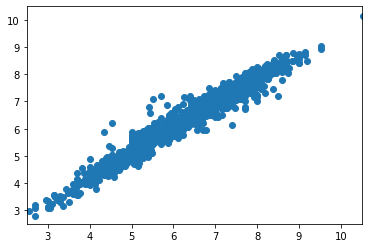

In [8]:
y_meas_train = transformers[0].untransform(train_dataset.y)
y_pred_train, y_pred_train_stds = predict_with_error(model, train_dataset.X, transformers[0])

plt.xlim([2.5, 10.5])
plt.ylim([2.5, 10.5])
plt.scatter(y_meas_train, y_pred_train)

现在，我们对我们的测试集执行同样的操作。我们看到了相当好的相关性！然而，它肯定没有那么紧。这反映在上面计算的 R2 分数之间的差异上。


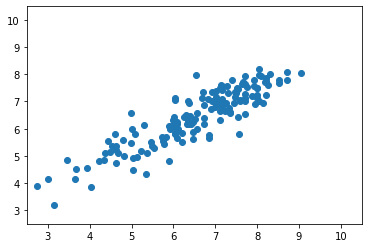

In [9]:
y_meas_test = transformers[0].untransform(test_dataset.y)
y_pred_test, y_pred_test_stds = predict_with_error(model, test_dataset.X, transformers[0])

plt.xlim([2.5, 10.5])
plt.ylim([2.5, 10.5])
plt.scatter(y_meas_test, y_pred_test)

我们还可以编写一个函数来计算有多少预测值落在预测误差范围内。这是通过计算有多少个样本的真实误差小于之前计算的标准偏差来实现的。一个标准差是68%的置信区间。


In [10]:
def percent_within_std(y_meas, y_pred, y_std):
    assert len(y_meas) == len(y_pred) and len(y_meas) == len(y_std), 'length of y_meas and y_pred must be the same'

    count_within_error = 0
    for i in range(len(y_meas)):
        if abs(y_meas[i][0]-y_pred[i]) < y_std[i]:
            count_within_error += 1

    return count_within_error/len(y_meas)

对于训练集，90%的样本在一个标准偏差内。相比之下，只有约70%的样本在测试集的标准偏差内。一个标准差是68%的置信区间所以我们看到对于训练集，不确定度很接近。然而，该模型过度预测了训练集的不确定性。

In [11]:
percent_within_std(y_meas_train, y_pred_train, y_pred_train_stds)

0.9355371900826446

In [12]:
percent_within_std(y_meas_test, y_pred_test, y_pred_test_stds)

0.7368421052631579

我们还可以看看测试集预测的标准偏差的分布。我们在预测误差中看到一个非常粗略的高斯分布。

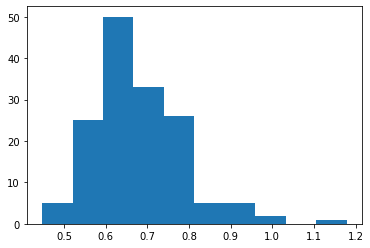

In [13]:
plt.hist(y_pred_test_stds)
plt.show()

现在，我们的教程到此结束。我们计划很快继续深入研究不确定性估计，特别是校准的不确定性估计。我们到时候见！

## 附录：Hyperparameter 优化

由于超参数优化超出了本教程的范围，所以我将不解释如何使用Optuna调优超参数。但是为了完整起见，仍然包含了代码。

In [ ]:
%pip install optuna
import optuna

In [ ]:
def get_model(trial):
    output_variance = trial.suggest_float('output_variance', 0.1, 10, log=True)
    length_scale = trial.suggest_float('length_scale', 1e-5, 1e5, log=True)
    noise_level = trial.suggest_float('noise_level', 1e-5, 1e5, log=True)

    params = {
        'kernel': output_variance**2 * RBF(length_scale=length_scale, length_scale_bounds='fixed') + WhiteKernel(noise_level=noise_level, noise_level_bounds='fixed'),
        'alpha': trial.suggest_float('alpha', 1e-12, 1e-5, log=True),
    }

    sklearn_gpr = GaussianProcessRegressor(**params)
    return dc.models.SklearnModel(sklearn_gpr)

def objective(trial):
    model = get_model(trial)
    model.fit(train_dataset)
    
    metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
    return model.evaluate(valid_dataset, [metric])['mean_squared_error']

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [ ]:
print(study.best_params)

{'output_variance': 0.38974570882583015, 'length_scale': 5.375387643239208, 'noise_level': 0.0016265333497286342, 'alpha': 1.1273318360324618e-11}
